# 6.6 UPDATE Sourcing & Analyzing Time Series Data

# Contents
    1. importing libraries
    2. Importing/cleaning data
    3. Preparing for time-series 
    4. Time-series analysis: decomposition
    5. Testing for stationarity
    6. Summary
    7. Bonus Task
        7.1 Defining Parameters
        7.2 Splitting the data
        7.3 Running and Fitting the Model
            7.3.1 Defining Parameters again
            7.3.2 Splitting the data again
            7.3.3 Running and Fitting the Model

# 1. Importing libraries

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html


# 2. Importing/cleaning data

In [2]:
# creating path for import
path = r'/Users/bdigregorio/Desktop/CareerFoundry/Data Immersion/Data Immersion 6/Flavors of Cacao Analysis'


In [3]:
# importing 'df_flavors_clean.csv'
df_fc3_B = pd.read_excel(os.path.join(path, '02 Data', 'Prepared Data', 'df_fc3_B.xlsx'))


In [4]:
# check import
df_fc3_B.head()

,Unnamed: 0,Company (Manufacturer),Company Location,Review Date,Country of Bean Origin,Specific Bean Origin or Bar Name,Cocoa Percent,Cocoa Level,Number_of_Ingredients,Ingredient Level,Rating,Rating Level,Ingredients_abbr,Most Memorable Characteristics
0,0,Manoa,U.S.A.,2012,Liberia,"Liberia, batch 174",0.72,Mid percent,3,3,3.25,Mid-level,"B,S,C","molassses, intense, off, herb"
1,1,Manoa,U.S.A.,2012,U.S.A.,"Hawai'i Island, Hamakua, Hawaiian Crown, b. 176",0.72,Mid percent,3,3,2.75,Mid-level,"B,S,C","oily, tangy, fruit, earthy"
2,2,Manoa,U.S.A.,2012,Peru,"Piura, batch 173",0.72,Mid percent,3,3,3.00,Mid-level,"B,S,C","banana, menthol, medicinal"
3,3,Manoa,U.S.A.,2012,U.S.A.,"O'ahu Island, Winward,Maunawili district, b. 151",0.72,Mid percent,3,3,3.25,Mid-level,"B,S,C","molasses, sweet, cocoa"
4,4,Nanea,U.S.A.,2013,U.S.A.,Criollo Blend,0.85,High percent,3,3,3.50,Mid-level,NaN,"sandy, spicy, earthy"


In [5]:
df_fc3_B.drop(columns = ['Unnamed: 0'], inplace=True)

In [6]:
df_fc3_B.head()

,Company (Manufacturer),Company Location,Review Date,Country of Bean Origin,Specific Bean Origin or Bar Name,Cocoa Percent,Cocoa Level,Number_of_Ingredients,Ingredient Level,Rating,Rating Level,Ingredients_abbr,Most Memorable Characteristics
0,Manoa,U.S.A.,2012,Liberia,"Liberia, batch 174",0.72,Mid percent,3,3,3.25,Mid-level,"B,S,C","molassses, intense, off, herb"
1,Manoa,U.S.A.,2012,U.S.A.,"Hawai'i Island, Hamakua, Hawaiian Crown, b. 176",0.72,Mid percent,3,3,2.75,Mid-level,"B,S,C","oily, tangy, fruit, earthy"
2,Manoa,U.S.A.,2012,Peru,"Piura, batch 173",0.72,Mid percent,3,3,3.00,Mid-level,"B,S,C","banana, menthol, medicinal"
3,Manoa,U.S.A.,2012,U.S.A.,"O'ahu Island, Winward,Maunawili district, b. 151",0.72,Mid percent,3,3,3.25,Mid-level,"B,S,C","molasses, sweet, cocoa"
4,Nanea,U.S.A.,2013,U.S.A.,Criollo Blend,0.85,High percent,3,3,3.50,Mid-level,NaN,"sandy, spicy, earthy"


# 3. Preparing for time-series 

In [7]:
# reviewing 'Review Date'
df_fc3_B['Review Date'].value_counts().sort_index(ascending=False)

2023     29
2022     98
2021    175
2020     81
2019    193
2018    228
2017    105
2016    217
2015    284
2014    247
2013    183
2012    194
2011    163
2010    110
2009    123
2008     92
2007     73
2006     62
Name: Review Date, dtype: int64

In [8]:
# reviewing 'Rating'
df_fc3_B['Rating'].value_counts().sort_index(ascending=False)

4.00    115
3.75    312
3.50    605
3.25    487
3.00    552
2.75    345
2.50    174
2.25     17
2.00     33
1.75      3
1.50     10
1.00      4
Name: Rating, dtype: int64

In [9]:
# reviewing 'Company Location'
df_fc3_B['Company Location'].value_counts()

U.S.A.        1207
Canada         185
France         184
U.K.           135
Italy           86
              ... 
Martinique       1
Reunion          1
Ghana            1
Suriname         1
Wales            1
Name: Company Location, Length: 66, dtype: int64

### I am going to do a time-series analysis using the U.S.A. yearly-average ratings.<br> I am using USA as it has the most value_counts.

In [10]:
# finding average ratings per year for USA 
USA_data = df_fc3_B.loc[(df_fc3_B['Company Location']== 'U.S.A.')]

In [11]:
USA_data.head()

,Company (Manufacturer),Company Location,Review Date,Country of Bean Origin,Specific Bean Origin or Bar Name,Cocoa Percent,Cocoa Level,Number_of_Ingredients,Ingredient Level,Rating,Rating Level,Ingredients_abbr,Most Memorable Characteristics
0,Manoa,U.S.A.,2012,Liberia,"Liberia, batch 174",0.72,Mid percent,3,3,3.25,Mid-level,"B,S,C","molassses, intense, off, herb"
1,Manoa,U.S.A.,2012,U.S.A.,"Hawai'i Island, Hamakua, Hawaiian Crown, b. 176",0.72,Mid percent,3,3,2.75,Mid-level,"B,S,C","oily, tangy, fruit, earthy"
2,Manoa,U.S.A.,2012,Peru,"Piura, batch 173",0.72,Mid percent,3,3,3.00,Mid-level,"B,S,C","banana, menthol, medicinal"
3,Manoa,U.S.A.,2012,U.S.A.,"O'ahu Island, Winward,Maunawili district, b. 151",0.72,Mid percent,3,3,3.25,Mid-level,"B,S,C","molasses, sweet, cocoa"
4,Nanea,U.S.A.,2013,U.S.A.,Criollo Blend,0.85,High percent,3,3,3.50,Mid-level,NaN,"sandy, spicy, earthy"


In [12]:
USA_data['Review Date'].dtype

dtype('int64')

In [13]:
USA_annual_mean_rating = USA_data.groupby(['Review Date'])['Rating'].mean().reset_index()


In [14]:
USA_annual_mean_rating 

,Review Date,Rating
0,2006,2.807692
1,2007,3.017241
2,2008,2.931818
3,2009,3.200000
4,2010,3.121622
5,2011,3.151515
6,2012,3.114362
7,2013,3.146341
8,2014,3.175847
9,2015,3.211149


In [15]:
USA_annual_mean_rating.shape

(18, 2)

In [16]:
USA_annual_mean_rating.columns

Index(['Review Date', 'Rating'], dtype='object')

In [17]:
type(USA_annual_mean_rating)

pandas.core.frame.DataFrame

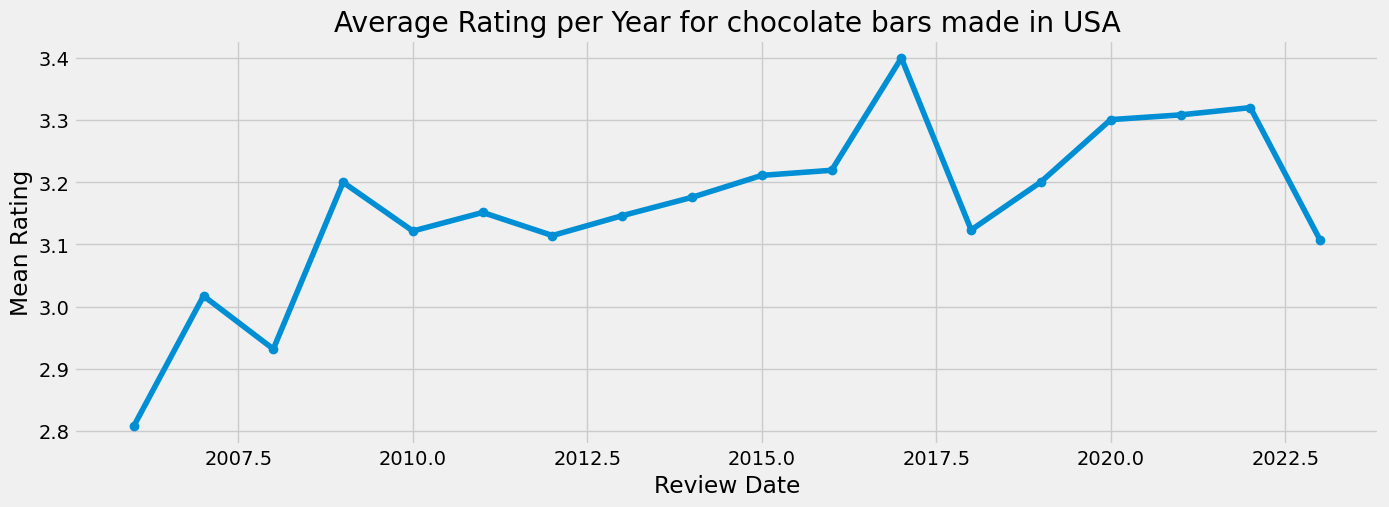

In [18]:
# Plot the data using matplotlib.

plt.figure(figsize=(15, 5), dpi=100)

# Specify x and y values for the plot
plt.plot(USA_annual_mean_rating['Review Date'], USA_annual_mean_rating['Rating'], marker='o')

# Add labels and title
plt.xlabel('Review Date')
plt.ylabel('Mean Rating')
plt.title('Average Rating per Year for chocolate bars made in USA')

# Display the plot
plt.show()

# 4. Time-series analysis: decomposition

In [19]:
# Reset index to use the "Review Date" column as a filter
USA_amr2 = USA_annual_mean_rating.reset_index(drop=True).set_index("Review Date")


In [20]:
USA_amr2.head()

,Rating
Review Date,
2006,2.807692
2007,3.017241
2008,2.931818
2009,3.200000
2010,3.121622


In [21]:
USA_amr2.shape

(18, 1)

In [22]:
USA_amr2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 2006 to 2023
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rating  18 non-null     float64
dtypes: float64(1)
memory usage: 288.0 bytes


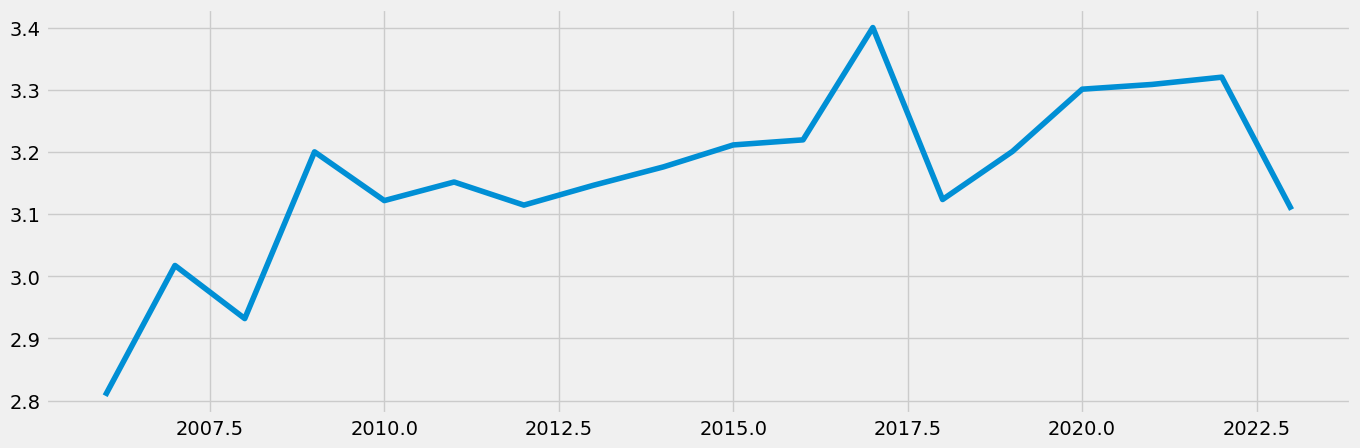

In [23]:
# confirming the new data set, USA_amr2, plot

plt.figure(figsize=(15,5), dpi=100)
plt.plot(USA_amr2)

In [24]:
# Check for missing values (you shouldn't have any)

USA_amr2.isnull().sum()

Rating    0
dtype: int64

In [25]:
# Check for duplicates

dups = USA_amr2.duplicated()
dups.sum()

0

### *No missing values or duplicates*

In [26]:
# Ensure that the "Review Date" column is in datetime format
USA_amr2.index = pd.to_datetime(USA_amr2.index)

# Infer the frequency of the index
freq = pd.infer_freq(USA_amr2.index)

# Set the frequency explicitly if it's not inferred
if freq is None:
    freq = 'AS' 

# Create a new datetime index with the correct years
years_range = range(2006, 2024)  # Assuming the range of years in your data
USA_amr2.index = pd.to_datetime(years_range, format='%Y')

# Check the DataFrame information
USA_amr2.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18 entries, 2006-01-01 to 2023-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rating  18 non-null     float64
dtypes: float64(1)
memory usage: 288.0 bytes


In [27]:
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(USA_amr2, model='additive', period=1)

In [28]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

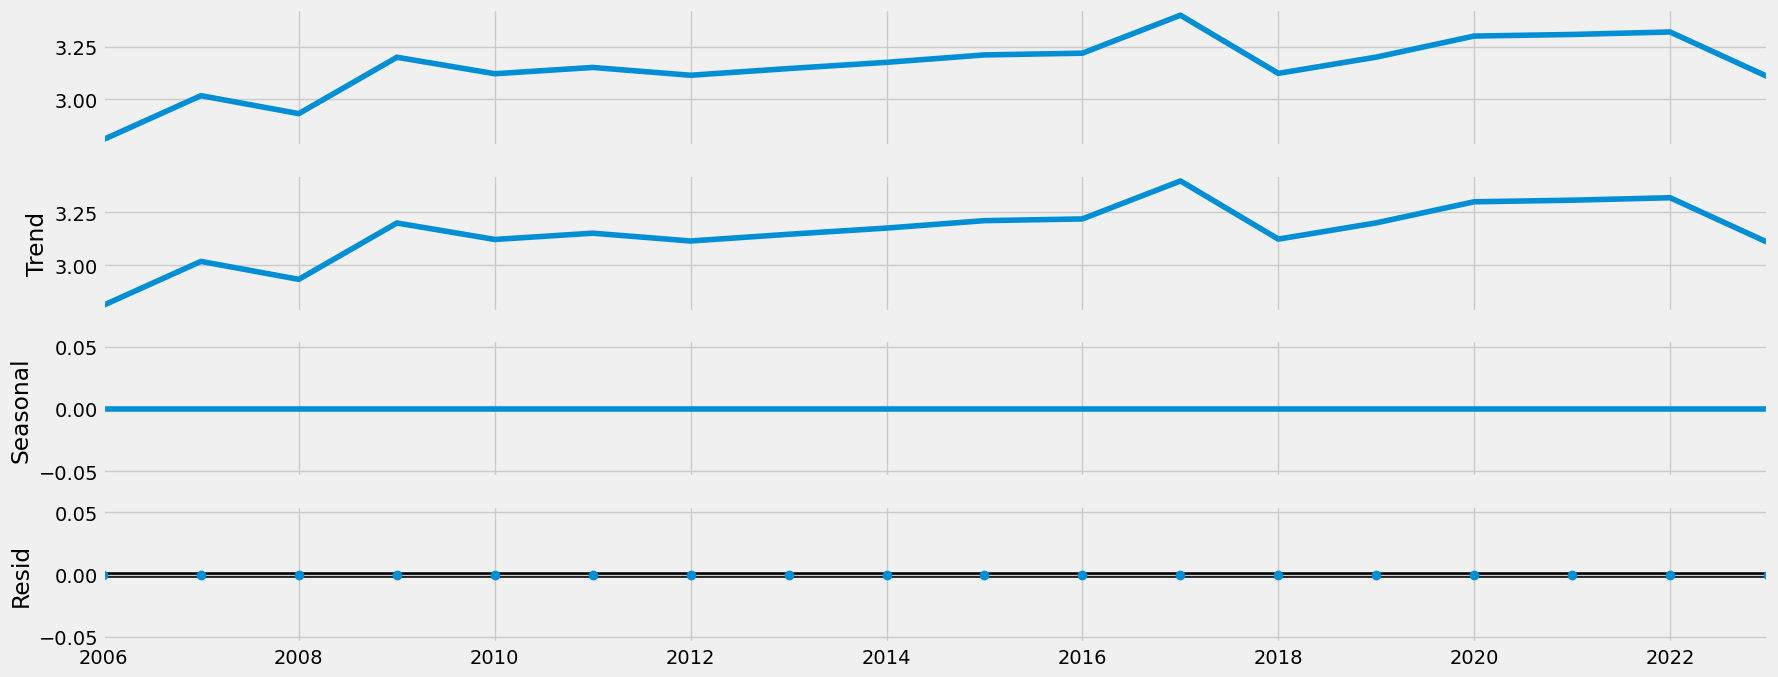

In [29]:
# Plot the separate components

decomposition.plot()
plt.show()

### In the decomposition plot above we see the observed data and the trend line are, to the eye, exactly the same. Meanwhile, the seasonality is a a straight lines and there is nothing on the residual line.<br> This might be telling us the decomposition plot may not be capturing particular aspects of the data and stationarity tests are required.




# 5. Testing for stationarity

In [30]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(USA_amr2['Rating'])

Dickey-Fuller Stationarity test:
Test Statistic                -20.991456
p-value                         0.000000
Number of Lags Used             7.000000
Number of Observations Used    10.000000
Critical Value (1%)            -4.331573
Critical Value (5%)            -3.232950
Critical Value (10%)           -2.748700
dtype: float64


### Oh my, the test statistic is incredibly smaller than *any* of the critical values! <br> -- The p-value is *zero*.<br> -- According to these stats I believe we can say this data is stationary, or more correctly stated, we have enough evidence to reject the null hypothesis of a unit root being present.
### Although this has some definitive results, let's check the autocorrelation plot...

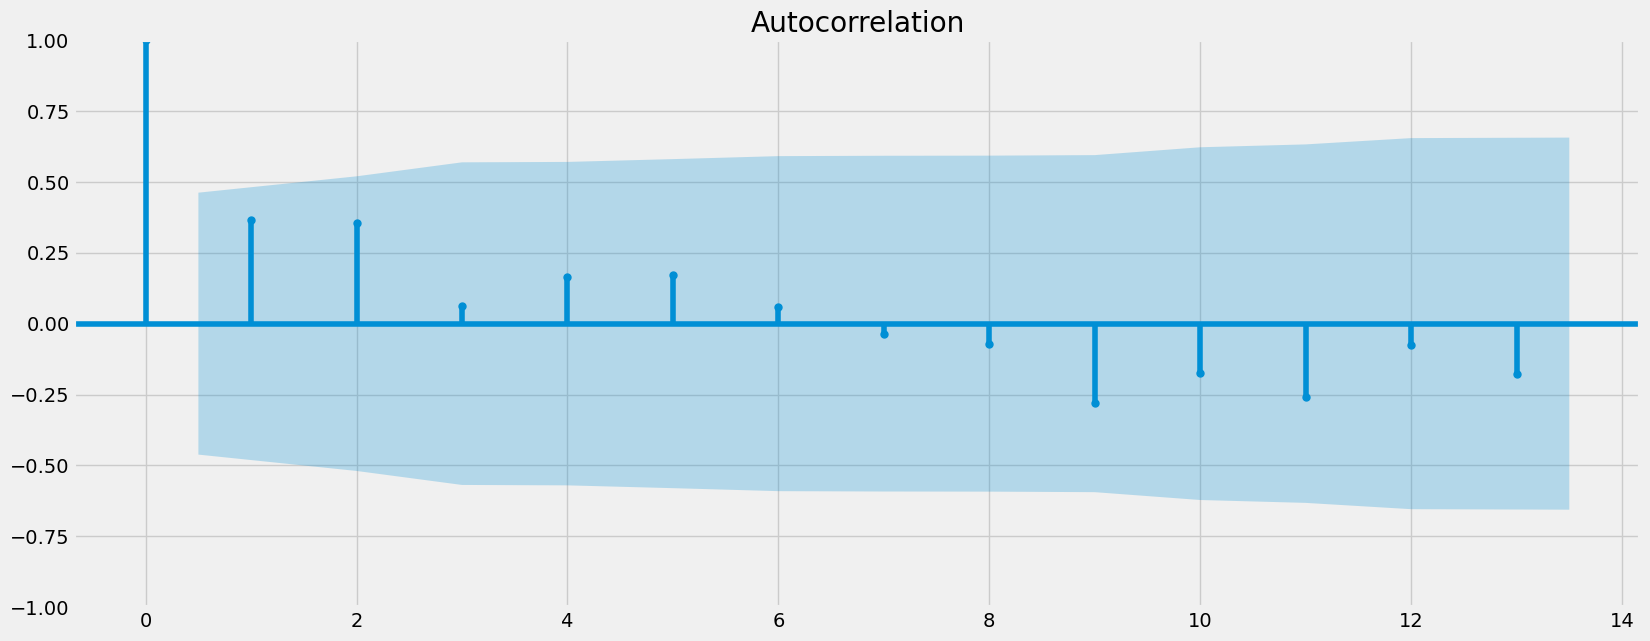

In [31]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(USA_amr2)
plt.show()

### There is only one line going above the blue confidence level. An indication that the lags are hardly and/or insignificantly correlated!

# 6. Summary

### Although in this time-series/rating script I only looked into chocolate bars made in the U.S.A., it would follow that the stationarity results are good when continuing on to the other categorical columns  such as a specific manufacturer, etc. (But that doesn't mean future tests should not be repeated!) 
### As we have been discovering through these analyses, it doesn't appear much of anything has a lasting, direct affect on the ratings of the chocolate bars, including the time of the tasting, as this script shows. Again, bringing to mind the subjective nature of "taste" amongst the rating participants and potential measurement and/or collection bias.
### But something good did happened in USA chocolate bar making amongst those recorded in this dataset around 2017 when the average yearly rating jumped to its highest level of 3.4.
### Next explorations to consider: can we discover why the jump in 2017 happened? What about specific manufacturers, specific beans, exploring specific ingredients and 'most memorable characteristics'? And what *does* make a highly-rated chocolate bar? I'd love to find out- with data AND taste!

 

# 7. Bonus Task

#      7.1 Defining Parameters

In [32]:
data_diff = USA_amr2 - USA_amr2.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)


In [33]:
data_diff.dropna(inplace = True)
data_diff.head()

,Rating
2007-01-01,0.209549
2008-01-01,-0.085423
2009-01-01,0.268182
2010-01-01,-0.078378
2011-01-01,0.029894


<Figure size 500x500 with 0 Axes>

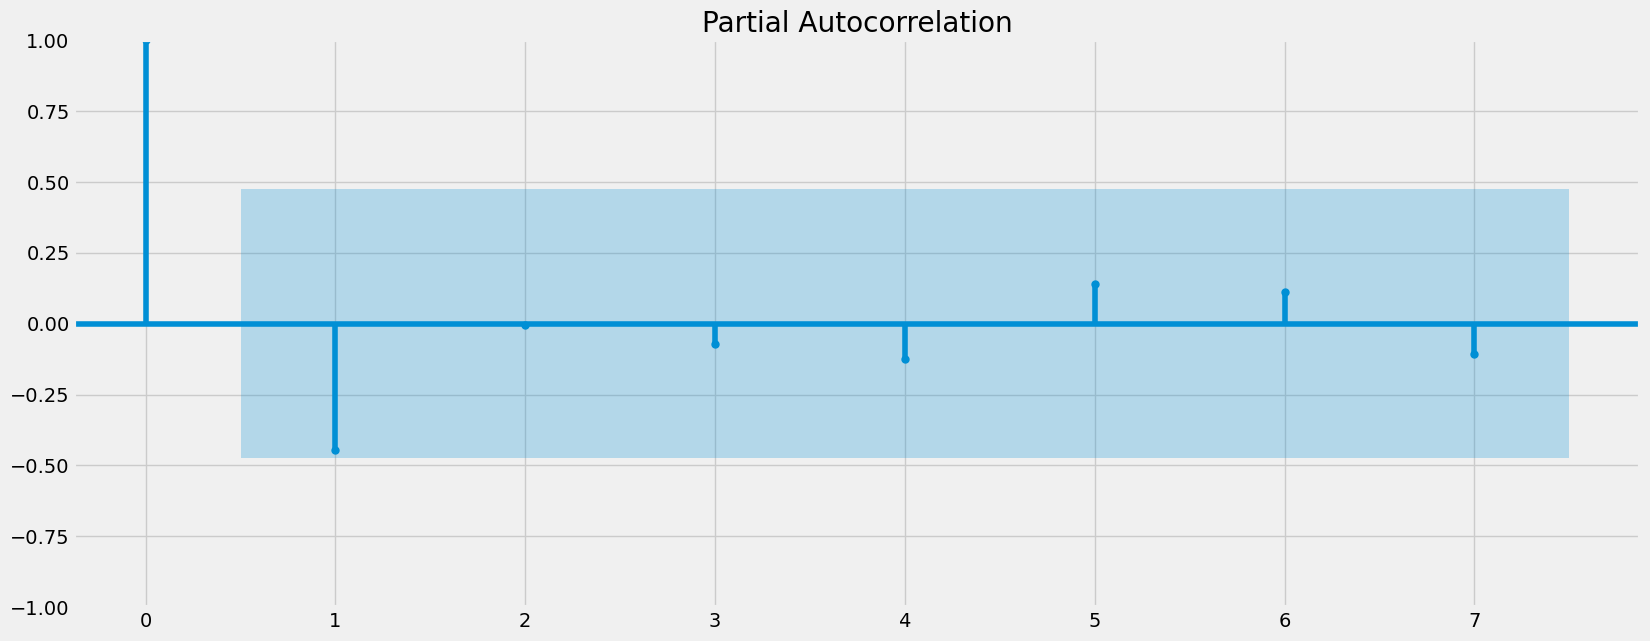

In [34]:
# Plot partial autocorrelations to determine parameter p

plt.figure(figsize=(5,5), dpi=100)
plot_pacf(data_diff, lags=7)
plt.show()

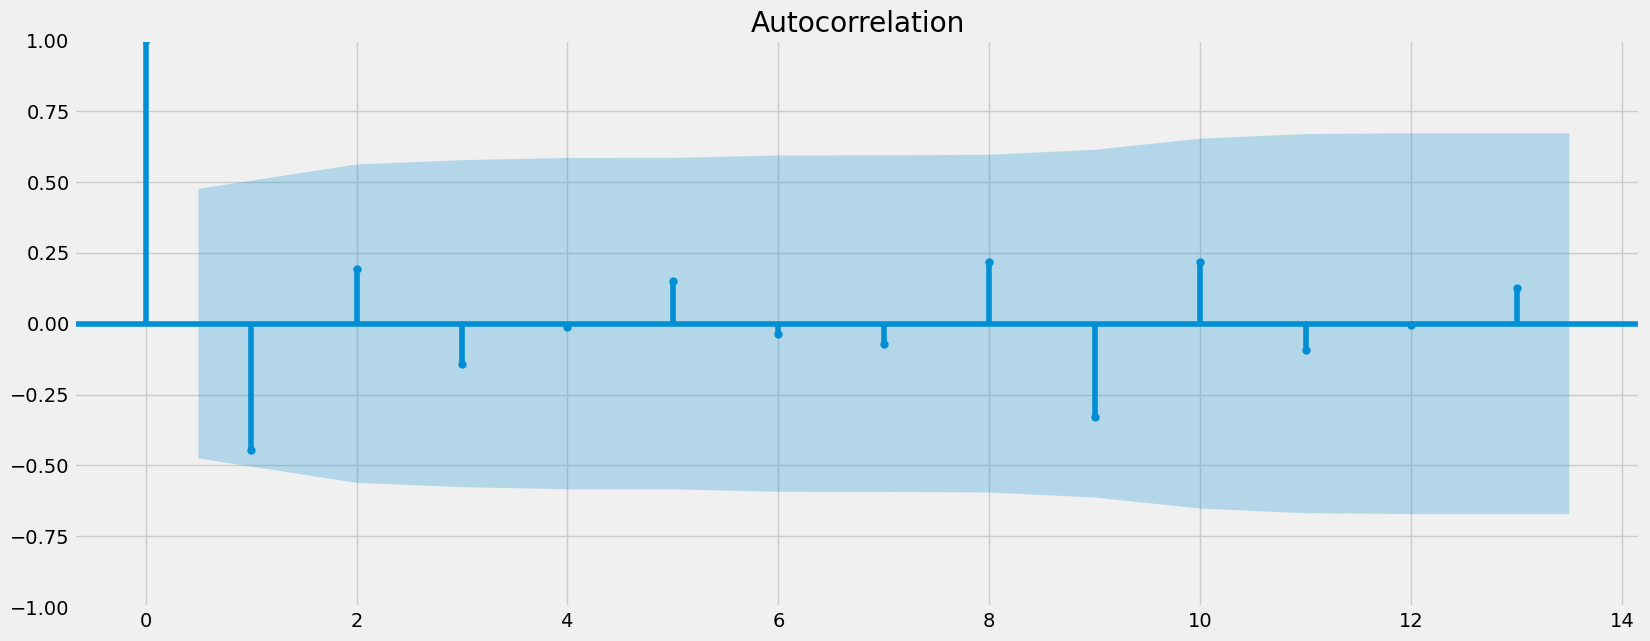

<Figure size 1500x500 with 0 Axes>

In [35]:
# Plot autocorrelations to determine parameter q

plot_acf(data_diff)
plt.figure(figsize=(15,5), dpi=100)
plt.show()

### I am going to choose AR=3 and MA=3.

# 7.2 Splitting the data

In [36]:
# Split the data

train = data_diff['Rating'][:13]
test = data_diff['Rating'][12:]

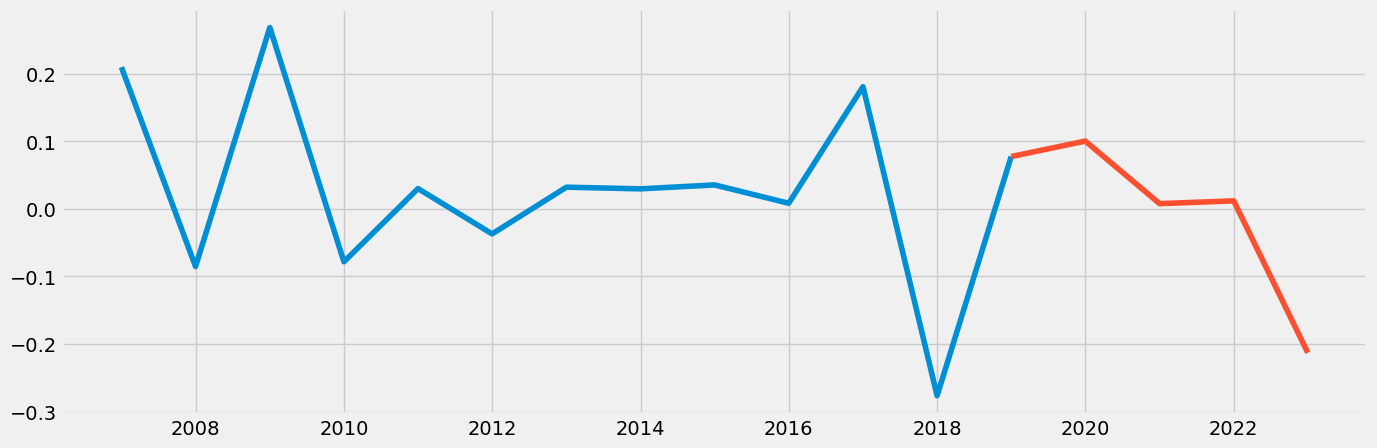

In [37]:
# Plot both sets in order to see the split

plt.figure(figsize=(15,5), dpi=100)
plt.plot(train)
plt.plot(test)

In [38]:
test.shape

(5,)

# 7.3 Running and Fitting the Model

In [39]:
# Import ARIMA model
from statsmodels.tsa.api import ARIMA

                               SARIMAX Results                                
Dep. Variable:                 Rating   No. Observations:                   13
Model:                 ARIMA(3, 1, 3)   Log Likelihood                   8.610
Date:                Sun, 12 Nov 2023   AIC                             -3.221
Time:                        16:37:30   BIC                              0.174
Sample:                    01-01-2007   HQIC                            -4.477
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4144      9.661     -0.043      0.966     -19.349      18.521
ar.L2          0.9473     13.616      0.070      0.945     -25.739      27.633
ar.L3          0.3727      4.442      0.084      0.9

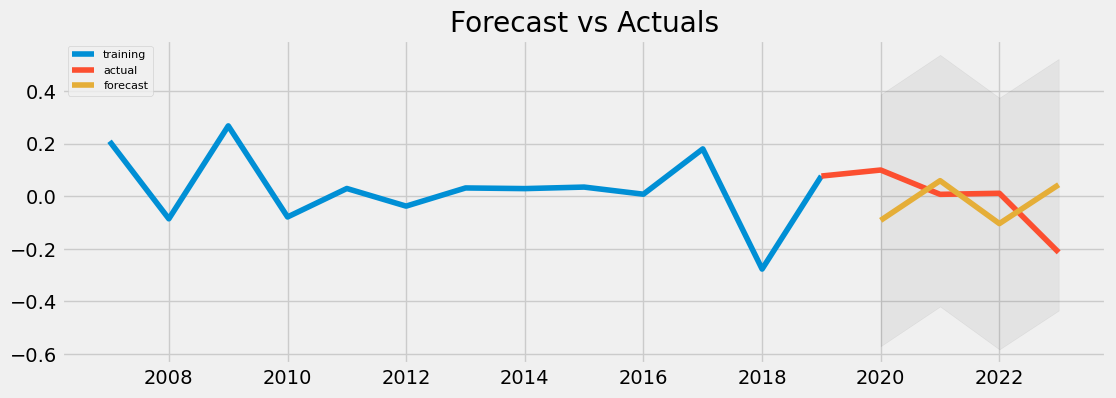

In [40]:
model = ARIMA(train, order=(3,1,3))  # Replace p, d, and q with appropriate values
fitted = model.fit()
print(fitted.summary())

# Forecast
forecast_steps = len(test)
fc = fitted.forecast(steps=forecast_steps, alpha=0.05)  # Forecasted values

# Compute standard errors
se = np.sqrt(fitted.forecast(steps=forecast_steps, alpha=0.05)[1])  # Standard errors

# Compute confidence interval
conf = 1.96 * se  # 95% confidence interval (for a two-sided interval)

# Create forecasted and confidence interval series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(fc - conf, index=test.index)
upper_series = pd.Series(fc + conf, index=test.index)

# Plot
plt.figure(figsize=(12, 4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### Above: None of the coefficients are statistically significant (p <= 0.05) but althought the forecast is is the confidence range not it looks different from the actual.

                               SARIMAX Results                                
Dep. Variable:                 Rating   No. Observations:                   13
Model:                 ARIMA(2, 1, 2)   Log Likelihood                   8.364
Date:                Sun, 12 Nov 2023   AIC                             -6.729
Time:                        16:37:30   BIC                             -4.304
Sample:                    01-01-2007   HQIC                            -7.626
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4134      1.032     -1.370      0.171      -3.436       0.609
ar.L2         -0.4151      0.906     -0.458      0.647      -2.191       1.361
ma.L1          0.2240      2.515      0.089      0.9

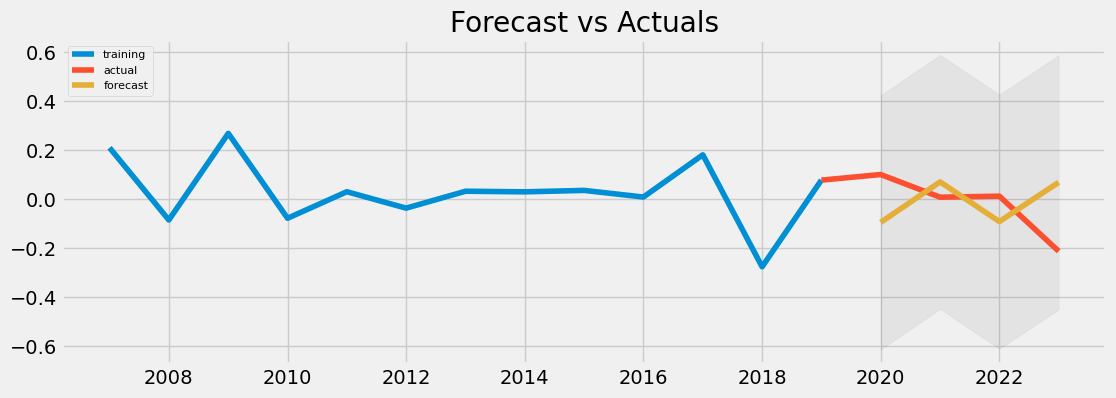

In [41]:
# iteration_2
model = ARIMA(train, order=(2,1,2))  # Replace p, d, and q with appropriate values
fitted = model.fit()
print(fitted.summary())

# Forecast
forecast_steps = len(test)
fc = fitted.forecast(steps=forecast_steps, alpha=0.05)  # Forecasted values

# Compute standard errors
se = np.sqrt(fitted.forecast(steps=forecast_steps, alpha=0.05)[1])  # Standard errors

# Compute confidence interval
conf = 1.96 * se  # 95% confidence interval (for a two-sided interval)

# Create forecasted and confidence interval series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(fc - conf, index=test.index)
upper_series = pd.Series(fc + conf, index=test.index)

# Plot
plt.figure(figsize=(12, 4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### In this iteration (2,1,2) the coefficients, again, are far from statistically significant but the is slighly more in line with the actual results.

# 7.3.1 Defining Parameters again

In [42]:
# running tests a second time
data_diff_2 = data_diff - data_diff.shift(1)

In [43]:
data_diff_2.dropna(inplace = True)
data_diff_2.head()

,Rating
2008-01-01,-0.294972
2009-01-01,0.353605
2010-01-01,-0.346560
2011-01-01,0.108272
2012-01-01,-0.067047


<Figure size 500x500 with 0 Axes>

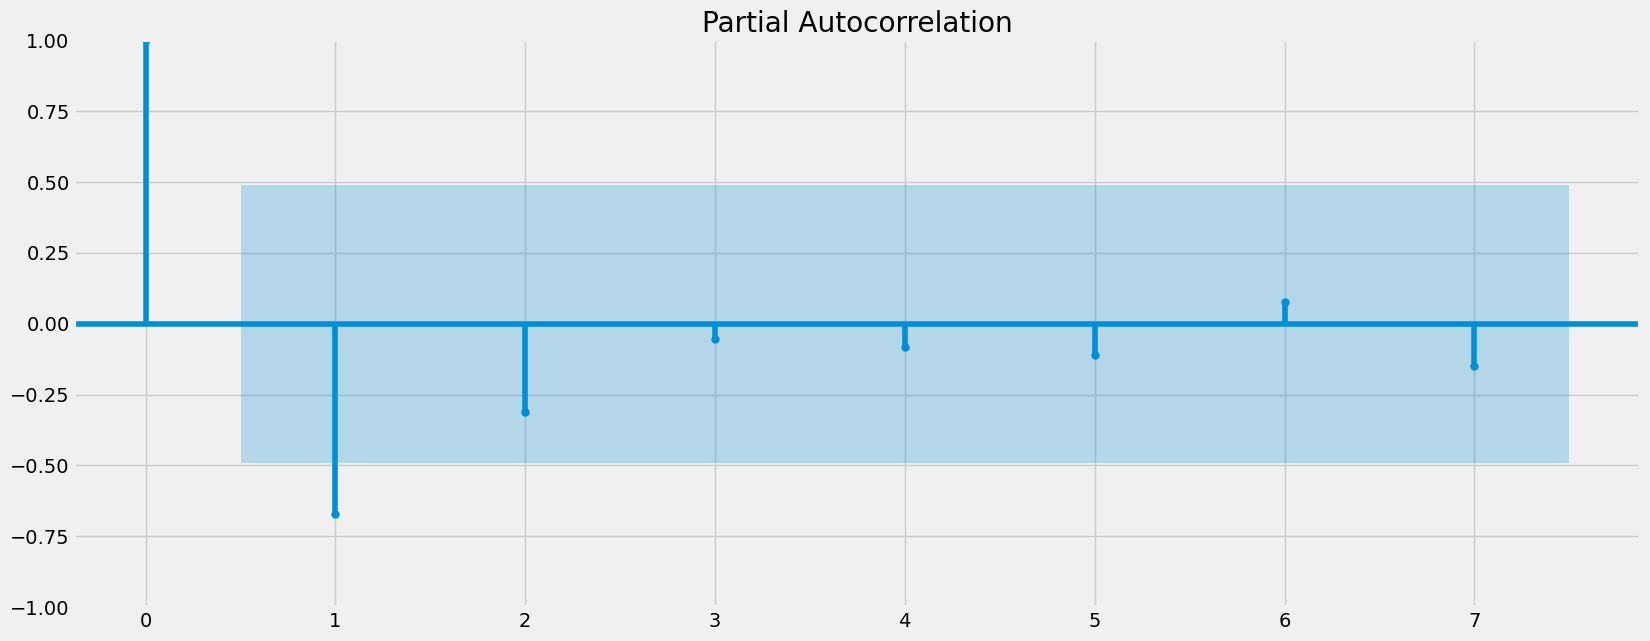

In [44]:
# Plot partial autocorrelations to determine parameter p

plt.figure(figsize=(5,5), dpi=100)
plot_pacf(data_diff_2, lags=7)
plt.show()

### Some difference from the first padf data_diff test.

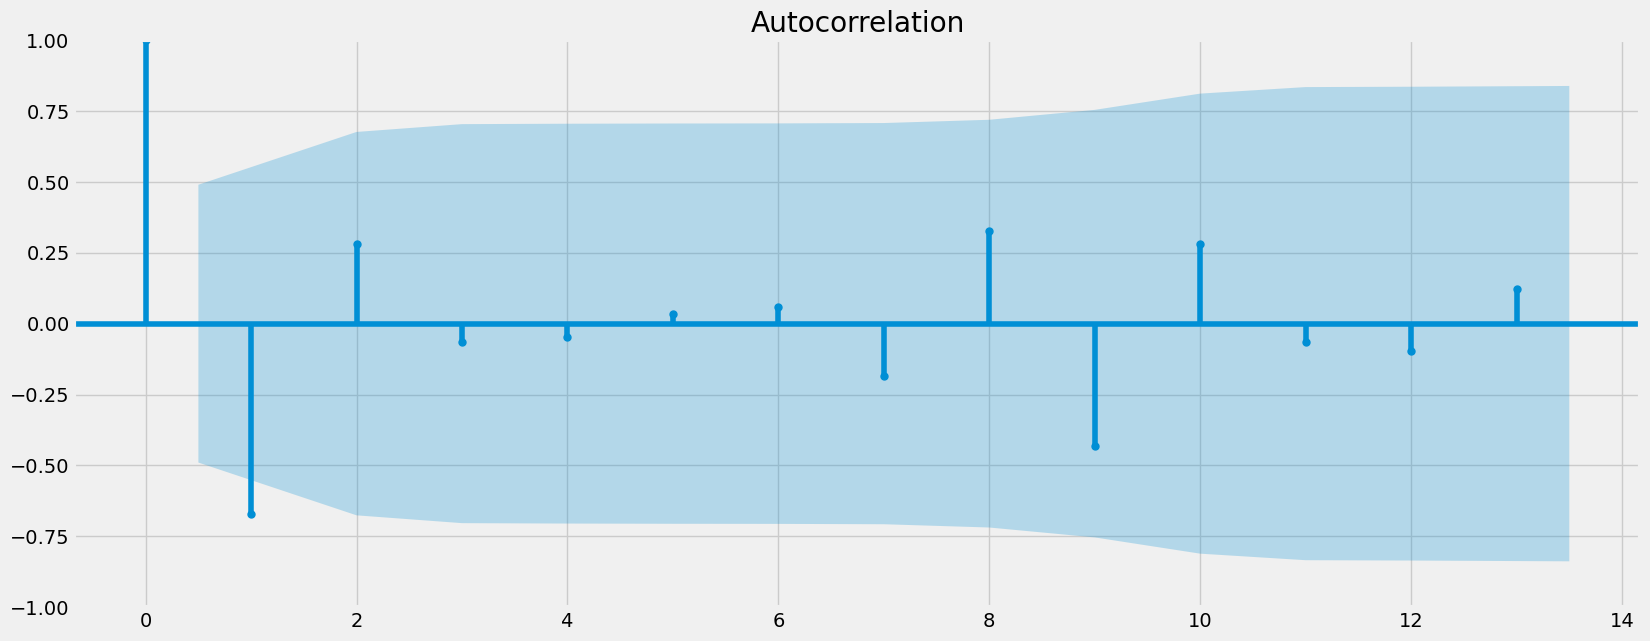

<Figure size 1500x500 with 0 Axes>

In [45]:
# Plot autocorrelations to determine parameter q

plot_acf(data_diff_2)
plt.figure(figsize=(15,5), dpi=100)
plt.show()

### Some difference, again, from the first acf data_diff test.

# 7.3.2 Splitting the data again

In [46]:
# Split the data

train = data_diff_2['Rating'][:13]
test = data_diff_2['Rating'][12:]

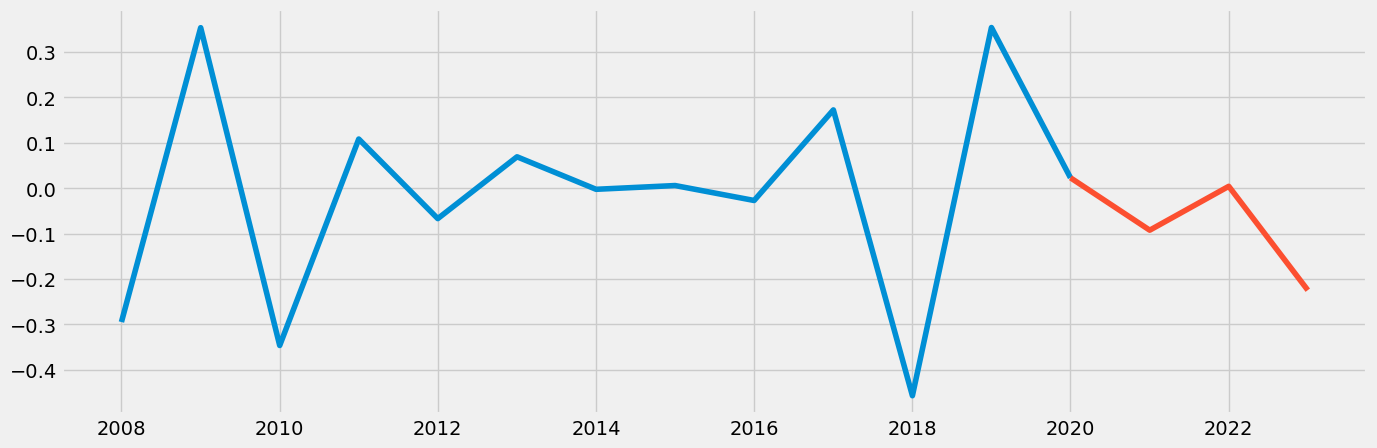

In [47]:
# Plot both sets in order to see the split

plt.figure(figsize=(15,5), dpi=100)
plt.plot(train)
plt.plot(test)

# 7.3.3 Running and Fitting the Model

                               SARIMAX Results                                
Dep. Variable:                 Rating   No. Observations:                   13
Model:                 ARIMA(4, 2, 4)   Log Likelihood                   0.853
Date:                Sun, 12 Nov 2023   AIC                             16.294
Time:                        16:37:31   BIC                             19.875
Sample:                    01-01-2008   HQIC                            14.037
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1729     25.410     -0.046      0.963     -50.975      48.630
ar.L2         -1.2807     27.201     -0.047      0.962     -54.595      52.033
ar.L3         -0.6355     23.218     -0.027      0.9

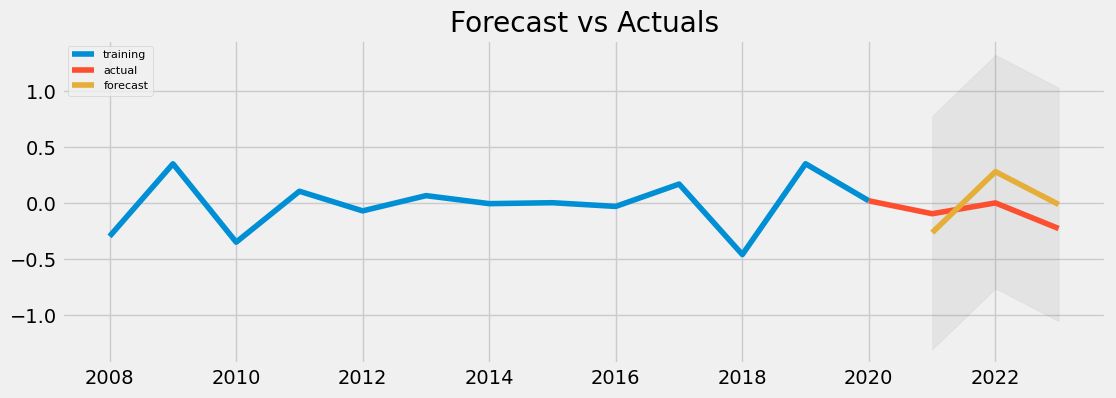

In [48]:
model = ARIMA(train, order=(4,2,4))  # Replace p, d, and q with appropriate values
fitted = model.fit()
print(fitted.summary())

# Forecast
forecast_steps = len(test)
fc = fitted.forecast(steps=forecast_steps, alpha=0.05)  # Forecasted values

# Compute standard errors
se = np.sqrt(fitted.forecast(steps=forecast_steps, alpha=0.05)[1])  # Standard errors

# Compute confidence interval
conf = 1.96 * se  # 95% confidence interval (for a two-sided interval)

# Create forecasted and confidence interval series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(fc - conf, index=test.index)
upper_series = pd.Series(fc + conf, index=test.index)

# Plot
plt.figure(figsize=(12, 4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## It looks like the forecast is similar to the actual results, a bit higher but on the right track. After several iterations this appears to be the closest fit.